# Le but de ce notebook est d'identifier des caractéristiques très simples permettant d'analyser des battements de coeur de foetus

In [6]:
import os
import pandas as pd
import numpy as np

# permet de charger les fichiers matlab (*.mat)
from scipy.io import loadmat

# le répertoire de travail
directory = os.path.abspath('')

# répertoire où se trouvent toutes les données associés à ce challenge
data_directory = os.path.join(directory, 'Data')

# fichier CSV contenant les targets (1 / 0)
targets_path = os.path.join(data_directory, 'CTG_Challenge_files_GroundTruth.csv')

# répertoire où se trouvent les fichiers de données matlab
matlab_directory = os.path.join(data_directory, 'ctg_workshop_database')

# dans l'électrocardiogramme, nous avons 4 mesures par seconde
# chaque mesure correspondent à au nombre de battements de coeurs par minute
elements_en_1s = 4
elements_en_30minutes = int(elements_en_1s*30*60)
elements_en_1heure = int(elements_en_1s*3600)

# retourne tous les fichiers matlab présents dans le repertoire 'path'
def all_mat_files_in_directory(path: str):
    return [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.mat')]

# calcule la moyenne de la séquence ''fhr' en ignorant les NaN
def moyenne(fhr):
    return fhr[~np.isnan(fhr)].mean()

# calcule la std dev de la séquence ''fhr' en ignorant les NaN
def volatilite(fhr):
    return fhr[~np.isnan(fhr)].std()

# nombre d elements NaN dans la séquence 'fhr'
def nan_count(fhr):
    return np.count_nonzero(np.isnan(fhr))



# Chargement des données d'entraînement

In [7]:
# chemin vers tous les fichiers matlab de la base d'entraînement
id_to_path = dict()
for filename in all_mat_files_in_directory(matlab_directory):
    filename_without_extension = os.path.splitext(os.path.basename(filename))[0]    
    id = filename_without_extension.lstrip('0')
    id_to_path[id] = filename

# on charge les targets associés à chaque fichier d'entraînement
targets_df = pd.read_csv(targets_path)
id_to_target = dict()
for _, row in targets_df.iterrows():
    id_to_target[str(row['ChallengeID'])] = row['TrueOutcome']

# lecture des battements de coeurs des foetus
id_to_fhr = dict()
all_lengths = []
for id, path in id_to_path.items():
    matlab_file = loadmat(path)
    id_to_fhr[id] = matlab_file['fhr']

    

# Calcul de statistiques sur ces données d'entraînement
## (pour faciliter la recherche des caractéristiques)

In [8]:

ids = []
targets = []

moyenne_full = []
volatilite_full = []
count_full = []
nan_count_full = []

moyenne_1ere_30minutes = []
volatilite_1ere_30minutes = []
count_1ere_30minutes = []
nan_count_1ere_30minutes = []

moyenne_derniere_30minutes = []
volatilite_derniere_30minutes = []
count_derniere_30minutes = []
nan_count_derniere_30minutes = []

moyenne_1ere_heure = []
volatilite_1ere_heure = []
count_1ere_heure = []
nan_count_1ere_heure = []

moyenne_derniere_heure = []
volatilite_derniere_heure = []
count_derniere_heure = []
nan_count_derniere_heure = []

for int_id in list(id_to_path.keys()):
    
    id = str(int_id)
    ids.append(id)
    targets.append(id_to_target[id])
    
    fhr_full = id_to_fhr[id].ravel() 
    
    moyenne_full.append(moyenne(fhr_full))
    volatilite_full.append(volatilite(fhr_full)) 
    count_full.append(fhr_full.size)
    nan_count_full.append(nan_count(fhr_full))

    fhr_1ere_30minutes = fhr_full[:elements_en_30minutes]
    moyenne_1ere_30minutes.append(moyenne(fhr_1ere_30minutes))
    volatilite_1ere_30minutes.append(volatilite(fhr_1ere_30minutes)) 
    count_1ere_30minutes.append(fhr_1ere_30minutes.size)
    nan_count_1ere_30minutes.append(nan_count(fhr_1ere_30minutes))
    
    fhr_derniere_30minutes = fhr_full[-elements_en_30minutes:]
    moyenne_derniere_30minutes.append(moyenne(fhr_derniere_30minutes))
    volatilite_derniere_30minutes.append(volatilite(fhr_derniere_30minutes)) 
    count_derniere_30minutes.append(fhr_derniere_30minutes.size)
    nan_count_derniere_30minutes.append(nan_count(fhr_derniere_30minutes))
    
    fhr_1ere_heure = fhr_full[:elements_en_1heure]
    moyenne_1ere_heure.append(moyenne(fhr_1ere_heure))
    volatilite_1ere_heure.append(volatilite(fhr_1ere_heure)) 
    count_1ere_heure.append(fhr_1ere_heure.size)
    nan_count_1ere_heure.append(nan_count(fhr_1ere_heure))
    
    fhr_derniere_heure = fhr_full[-elements_en_1heure:]
    moyenne_derniere_heure.append(moyenne(fhr_derniere_heure))
    volatilite_derniere_heure.append(volatilite(fhr_derniere_heure)) 
    count_derniere_heure.append(fhr_derniere_heure.size)
    nan_count_derniere_heure.append(nan_count(fhr_derniere_heure))

    
# plus petite taille dans le dataset
# min([t[~np.isnan(t)].size for t in challengeid_to_fhr.values()])
 
# Sauvegarde de ces statistiques dans un DataFrame
fhr_stats = pd.DataFrame(
    {'ids': ids,
    'targets': targets,
    'moyenne_full' : moyenne_full,
    'volatilite_full' : volatilite_full,
    'count_full' : count_full,
    'nan_count_full' : nan_count_full,
    'moyenne_1ere_30minutes' : moyenne_1ere_30minutes,
    'volatilite_1ere_30minutes' : volatilite_1ere_30minutes,
    'count_1ere_30minutes' : count_1ere_30minutes,
    'nan_count_1ere_30minutes' : nan_count_1ere_30minutes,
    'moyenne_derniere_30minutes' : moyenne_derniere_30minutes,
    'volatilite_derniere_30minutes' : volatilite_derniere_30minutes,
    'count_derniere_30minutes' : count_derniere_30minutes,
    'nan_count_derniere_30minutes' : nan_count_derniere_30minutes,
    'moyenne_1ere_heure' : moyenne_1ere_heure,
    'volatilite_1ere_heure' : volatilite_1ere_heure,
    'count_1ere_heure' : count_1ere_heure,
    'nan_count_1ere_heure' : nan_count_1ere_heure,
    'moyenne_derniere_heure' : moyenne_derniere_heure,
    'volatilite_derniere_heure' : volatilite_derniere_heure,
    'count_derniere_heure' : count_derniere_heure,
    'nan_count_derniere_heure' : nan_count_derniere_heure,
    })

# on sauvegarde ces stats sur le disque
fhr_stats.to_csv(os.path.join(directory, 'fhr_stats.csv'), index=False)    

# Affichage d'un électrocardiogramme

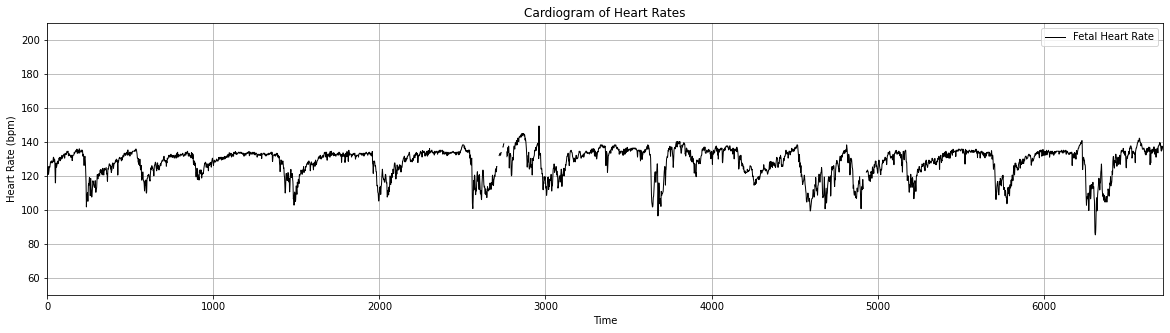

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# id de l'électrocardiogramme à afficher
id = '129'
# nous ne gardons que les 28 dernières minutes de l'enregistrement:
# (pour être aligné avec les fichiers pdf du répertoire 'ctg_data')
# Il y a 4 mesures par seconde: nous devons donc garder les 4*60*28 dernières valeurs
fhr = loadmat(id_to_path[id])['fhr'].ravel()[-1*4*60*28:]

# nombre d'éléments dans l'électrocardiogramme
n = len(fhr)

# Create an array of time points (assuming each heart rate measurement is taken at regular intervals)
time = np.arange(n)

# Plot the heart rate data
plt.figure(figsize=(20, 5))
plt.plot(time, fhr, linestyle='-', color='black', linewidth=1,label='Fetal Heart Rate')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.title('Cardiogram of Heart Rates')
plt.legend()
plt.xlim(0, n-1)
plt.ylim(50, 210)
# Display grid
plt.grid(True)

# Show the plot
plt.show()